# Exercises
- file name: `time_series_anomaly_detection.py` or `time_series_anomaly_detection.ipynb`

The dataset for these exercises lives in the Codeup Data Science MySQL Server. The database name is curriculum_logs.

**Hint**: You will need to explore the database (yay SQL!)

1. Label students by the program they are in.
1. Is it possible to identify the user_id of a staff member?
1. Identify students who are accessing our curriculum pages beyond the end of their time at Codeup.
1. Identify students who present anomalous activity using the Bollinger Band method, but reduce K to 2. 
1. Plot the access activity of these students.

**BONUS:** Can you identify users who are viewing both the web dev and data science curriculum?

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

# standard data science libraries
import numpy as np
import pandas as pd
import seaborn as sns

# custom module
import src.env as env

### Built query for SQL

In [2]:
'''
*SQL query*
USE curriculum_logs;

SELECT date, time as access_time, path as endpoint, user_id, cohort_id, ip as ip_source,
id, name as username, slack as handle, start_date as program_start, end_date as program_end, program_id
FROM logs
AS a

LEFT JOIN cohorts AS b ON a.cohort_id = b.id
'''

'\n*SQL query*\nUSE curriculum_logs;\n\nSELECT date, time as access_time, path as endpoint, user_id, cohort_id, ip as ip_source,\nid, name as username, slack as handle, start_date as program_start, end_date as program_end, program_id\nFROM logs\nAS a\n\nLEFT JOIN cohorts AS b ON a.cohort_id = b.id\n'

### Use SQL query with credentials to add sql output to pandas dataframe

In [3]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
query = '''
SELECT date, time as access_time, path as endpoint, user_id, cohort_id, ip as ip_source,
id, name as username, slack as handle, start_date as program_start, end_date as program_end, program_id
FROM logs
AS a

LEFT JOIN cohorts AS b ON a.cohort_id = b.id
'''
df = pd.read_sql(query, url)
df.head()

,date,access_time,endpoint,user_id,cohort_id,ip_source,id,username,handle,program_start,program_end,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,1.0
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,1.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,1.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,1.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2.0


In [5]:
df.shape

(900223, 12)

### 900,000 observations. This is a pretty big dataframe

### Setting index to date

In [52]:
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)

df.head()

,date,access_time,endpoint,user_id,cohort_id,ip_source,cohort_name,handle,program_start,program_end,program_id
date,,,,,,,,,,,
2018-01-26,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,1.0
2018-01-26,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,1.0
2018-01-26,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,1.0
2018-01-26,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,1.0
2018-01-26,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,#teddy,2018-01-08,2018-05-17,2.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 900223 entries, 2018-01-26 to 2021-04-21
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date           900223 non-null  datetime64[ns]
 1   access_time    900223 non-null  object        
 2   endpoint       900222 non-null  object        
 3   user_id        900223 non-null  int64         
 4   cohort_id      847330 non-null  float64       
 5   ip_source      900223 non-null  object        
 6   id             847330 non-null  float64       
 7   username       847330 non-null  object        
 8   handle         847330 non-null  object        
 9   program_start  847330 non-null  object        
 10  program_end    847330 non-null  object        
 11  program_id     847330 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(7)
memory usage: 89.3+ MB


### Engineering features to operate a bit more quickly

In [29]:
df['cohort_id'].isnull().sum(), df['program_id'].isnull().sum()

(52893, 52893)

In [ ]:
df['user_id'] = df['user_id'].astype('uint8')
#df['cohort_id'] = df['cohort_id'].astype('int')
# df.drop(columns=['year_built', 'fips'], inplace=True)
df.drop(columns=['id'], inplace=True)
#df['program_id'] = df['program_id'].astype('int')
df.rename(columns={'username' : 'cohort_name'}, inplace=True)

<div class = "alert alert-block alert-info">

## 2. Is it possible to identify the user_id of a staff member?

In [42]:
df['cohort_name'].unique().tolist()

['Hampton',
 'Teddy',
 'Sequoia',
 'Arches',
 'Niagara',
 'Pinnacles',
 'Quincy',
 None,
 'Kings',
 'Lassen',
 'Mammoth',
 'Glacier',
 'Denali',
 'Joshua',
 'Olympic',
 'Ulysses',
 'Badlands',
 'Apollo',
 'Ike',
 'Voyageurs',
 'Wrangell',
 'Xanadu',
 'Franklin',
 'Yosemite',
 'Staff',
 'Zion',
 'Andromeda',
 'Betelgeuse',
 'Ceres',
 'Bayes',
 'Deimos',
 'Europa',
 'Fortuna',
 'Curie',
 'Apex',
 'Ganymede',
 'Everglades',
 'Hyperion',
 'Darden',
 'Bash',
 'Jupiter',
 'Kalypso',
 'Luna',
 'Easley',
 'Marco',
 'Neptune',
 'Florence',
 'Oberon']

In [51]:
df.cohort_name[df['cohort_name'] == 'Staff'].count()

84031

In [49]:
df.handle[df['handle'] == '#'].count()

110569

### It appears that we can identify staff members under the cohort_name of "Staff" but not by features such as program_id. There seems to be a relationship between slack handle of just # and staff members as well. 

<div class = "alert alert-block = alert-info">


## 3. Identify students who are accessing our curriculum pages beyond the end of their time at Codeup.

In [53]:
pages = df['endpoint'].resample('d').count()
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: endpoint, dtype: int64

### I want to create an exponential moving average for the users in the dataframe based around weekly, monthly, and quarterly behavior

In [66]:
# 7 day EMA
ema_7d = pages.ewm(span=7).mean()
ema_30d = pages.ewm(span=30).mean()
ema_90d = pages.ewm(span=90).mean()


In [63]:
ema_7d.head()

date
2018-01-26    572.000000
2018-01-27    376.571429
2018-01-28    287.243243
2018-01-29    485.737143
2018-01-30    540.235595
Freq: D, Name: endpoint, dtype: float64

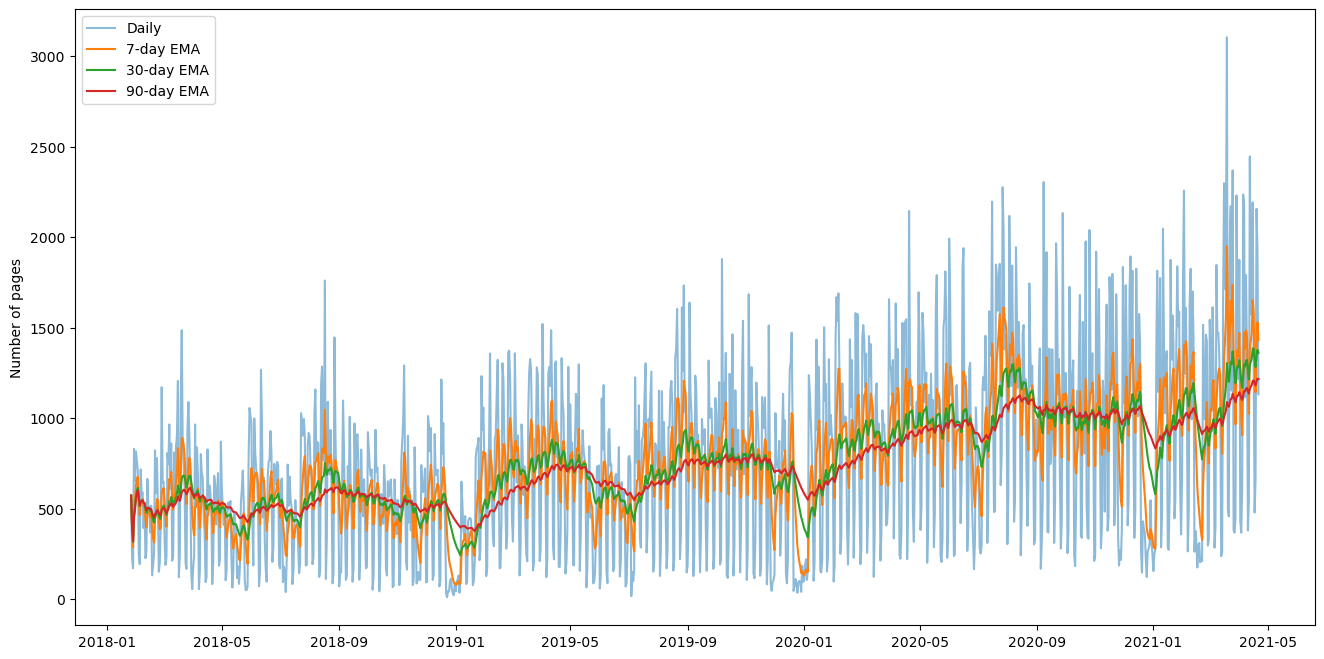

In [67]:
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(pages.index, pages, label='Daily', alpha=.5)

ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

In [69]:
#setting terms which will modify the chart in unison
span = 30
distance = 3

#creating the 'mid band by averaging the values in a time period (span)
midband = pages.ewm(span=span).mean()

#creating the upper and lower bands as multiples of standard deviations from the midband
midband_std = pages.ewm(span=span).std()

ub = midband + midband_std * distance
lb = midband - midband_std * distance

In [72]:
#concating the different bands together into a dataframe with pages
banded_pages = pd.concat([pages, midband, ub, lb], axis=1)
banded_pages.columns = ['pages', 'midband', 'ub', 'lb']
banded_pages.head()

,pages,midband,ub,lb
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557
2018-01-28,170,315.139578,956.773991,-326.494835
2018-01-29,830,457.002386,1406.405897,-492.401124
2018-01-30,652,501.369064,1354.808245,-352.070116


### plotting bands around the days representing anomalous daily access to the codeup webserver

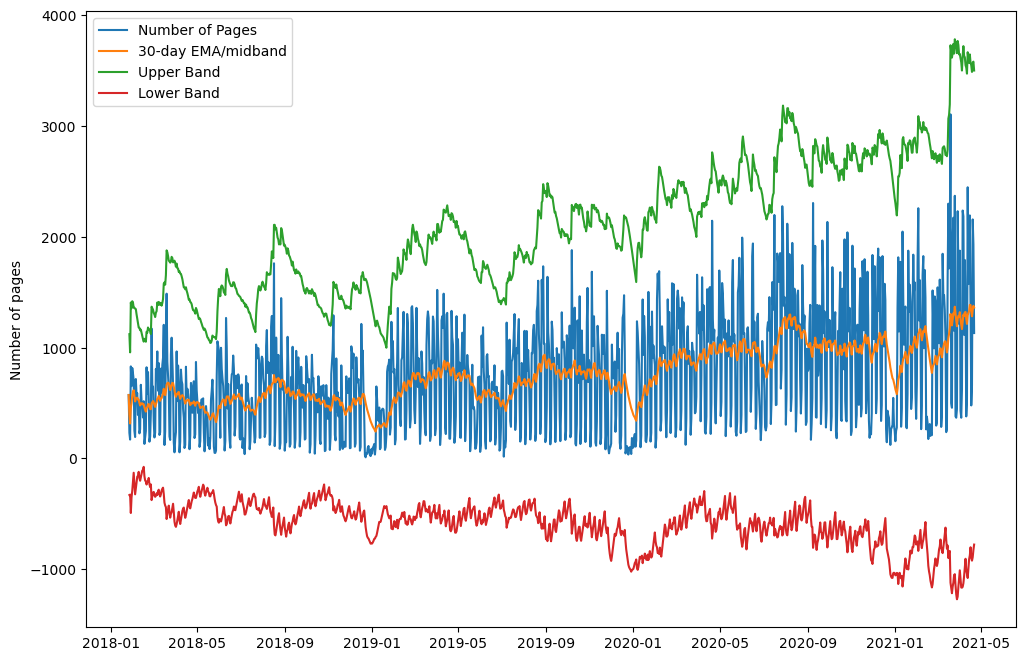

In [73]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(banded_pages.index, banded_pages.pages, label='Number of Pages')

ax.plot(banded_pages.index, banded_pages.midband, label = '30-day EMA/midband')
ax.plot(banded_pages.index, banded_pages.ub, label = 'Upper Band')
ax.plot(banded_pages.index, banded_pages.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

### Computing bollinger bands

In [75]:
'''
the previous entry - lower bound of today's entry 
divided by
upper bound of today's entry - lower bound of today's entry
'''

# bollinger bands - representing differences between upper and lower bound figures
banded_pages['pct_b'] = (banded_pages['pages'] - banded_pages['lb'])/(banded_pages['ub'] - banded_pages['lb'])
banded_pages.head()

,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557,0.386077
2018-01-28,170,315.139578,956.773991,-326.494835,0.386899
2018-01-29,830,457.002386,1406.405897,-492.401124,0.696438
2018-01-30,652,501.369064,1354.808245,-352.070116,0.588249


### How many anomaly's are detected?

In [77]:
banded_pages[banded_pages['pct_b']>1]

,pages,midband,ub,lb,pct_b
date,,,,,


In [78]:
df.head()

,date,access_time,endpoint,user_id,cohort_id,ip_source,cohort_name,handle,program_start,program_end,program_id
date,,,,,,,,,,,
2018-01-26,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,1.0
2018-01-26,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,1.0
2018-01-26,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,1.0
2018-01-26,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,1.0
2018-01-26,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,#teddy,2018-01-08,2018-05-17,2.0


In [79]:
def one_user_df_prep(df, user):
    '''
    This function returns a dataframe consisting of data for only a single defined user
    '''
    df = df[df.user_id == user]
    #df.date = pd.to_datetime(df.date)
    #df = df.set_index(df.date)
    pages_one_user = df['endpoint'].resample('d').count()
    return pages_one_user

In [ ]:
def compute_pct_b(pages_one_user, span, weight, user):
    '''
    This function adds the %b of a bollinger band range for the page views of a single user's log activity
    '''
    # Calculate upper and lower bollinger band
    midband = pages_one_user.ewm(span=span).mean()
    stdev = pages_one_user.ewm(span=span).std()
    ub = midband + stdev * distance
    lb = midband - stdev * distance
    
    # Combine all data into a single dataframe
    banded_pages = pd.concat([pages, midband, ub, lb], axis=1)
    banded_pages.columns = ['pages', 'midband', 'ub', 'lb']
    
    # Calculate percent b and relevant user id to dataframe
    banded_pages['pct_b'] = (banded_pages['pages_one_user'] - banded_pages['lb'])/(banded_pages['ub'] - banded_pages['lb'])
    banded_pages['user_id'] = user
    return my_df